# Show picture


0: 448x640 (no detections), 391.7ms
Speed: 25.3ms preprocess, 391.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

Detection Details for Winter-Fishing-On-Ice-sealed-Chagan-Lake.jpg:
--------------------------------------------------
Maximum pixel difference: 0

0: 448x640 1 orange, 146.1ms
Speed: 6.2ms preprocess, 146.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

Detection Details for test1.jpg:
Detection 1:
- Class: orange
- Confidence: 0.92
- Bounding Box: [     1771.7      909.62      3555.9      2835.9]
--------------------------------------------------
Maximum pixel difference: 0

0: 640x640 1 orange, 175.2ms
Speed: 5.8ms preprocess, 175.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

Detection Details for test2.jpg:
Detection 1:
- Class: orange
- Confidence: 0.89
- Bounding Box: [     65.624      51.612      548.96      553.67]
--------------------------------------------------
Maximum pixel difference: 0

0: 44

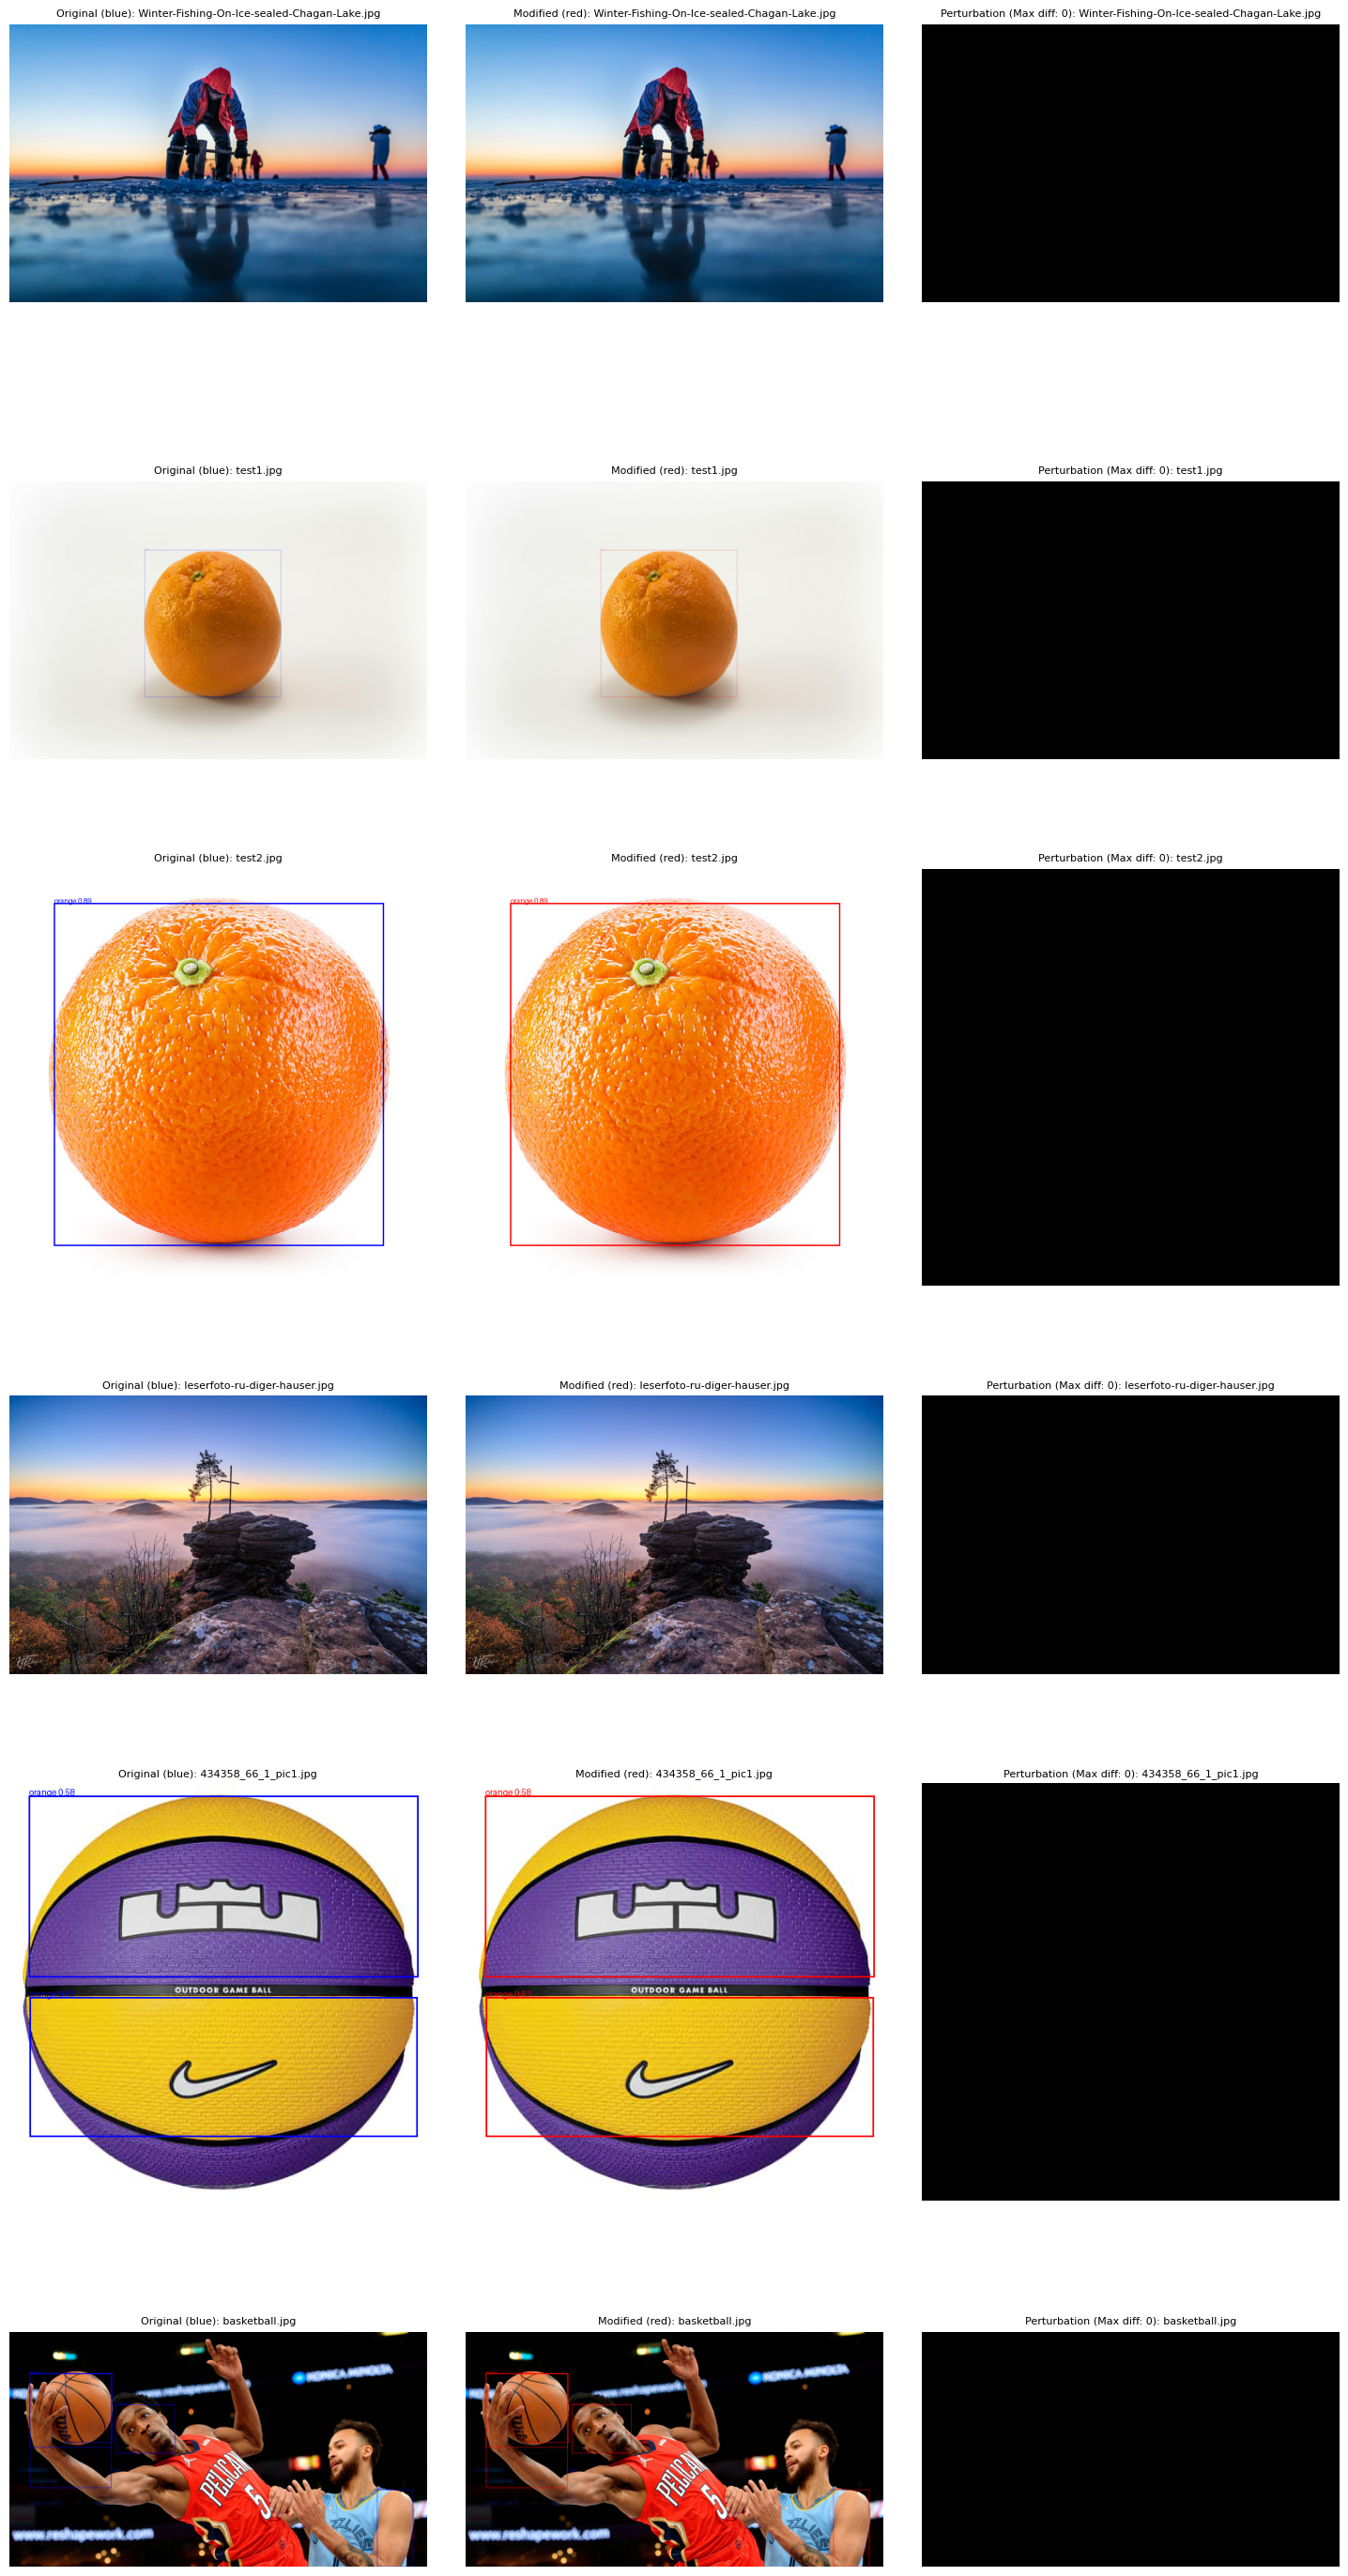

In [6]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import numpy as np


def load_model(model_path):
    """
    Load the YOLO model from the specified path.
    """
    return YOLO(model_path)


def get_image_files(folder, extensions=('.jpg', '.jpeg', '.png')):
    """
    Get a list of image files from the specified folder with the given extensions.
    """
    return [f for f in Path(folder).glob('*') if f.suffix.lower() in extensions]


def process_image(model, image_path, conf_threshold=0.25):
    """
    Process an image with the model to get predictions, and return the original,
    modified, and difference images along with the detection results.
    """
    # Load the original image
    original_image = Image.open(image_path)
    original_array = np.array(original_image)

    # Create a copy for modification (before drawing boxes)
    modified_image = original_image.copy()
    modified_array = np.array(modified_image)  # Store modified array before drawing boxes

    # Create copies for display with boxes
    display_image = original_image.copy()
    final_modified_image = original_image.copy()

    draw_display = ImageDraw.Draw(display_image)
    draw_modified = ImageDraw.Draw(final_modified_image)

    # Run predictions
    results = model.predict(original_image, conf=conf_threshold)
    result = results[0]

    # Draw boxes on display images
    for box in result.boxes:
        x1, y1, x2, y2 = box.xyxy[0].numpy()
        conf = box.conf[0]
        cls = box.cls[0]
        label = f"{result.names[int(cls)]} {conf:.2f}"

        # Draw blue boxes on display image
        draw_display.rectangle([x1, y1, x2, y2], outline="blue", width=2)
        draw_display.text((x1, y1 - 10), label, fill="blue")

        # Draw red boxes on final modified image
        draw_modified.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw_modified.text((x1, y1 - 10), label, fill="red")

    # Calculate perturbation between original and modified (before boxes)
    perturbation = np.abs(original_array.astype(int) - modified_array.astype(int)).astype(np.uint8)

    return np.array(display_image), np.array(final_modified_image), perturbation, result


def plot_images(subplot_idx, image_path, display_image, modified_image, perturbation, num_images):
    """
    Plot images with titles.
    """
    rows = (num_images * 3 + 2) // 3
    plt.subplot(rows, 3, subplot_idx * 3 + 1)
    plt.imshow(display_image)
    plt.title(f"Original (blue): {image_path.name}", fontsize=8)
    plt.axis('off')

    plt.subplot(rows, 3, subplot_idx * 3 + 2)
    plt.imshow(modified_image)
    plt.title(f"Modified (red): {image_path.name}", fontsize=8)
    plt.axis('off')

    plt.subplot(rows, 3, subplot_idx * 3 + 3)
    plt.imshow(perturbation)
    perturbation_magnitude = np.max(perturbation)
    plt.title(f"Perturbation (Max diff: {perturbation_magnitude}): {image_path.name}", fontsize=8)
    plt.axis('off')


def print_detection_details(result, image_path):
    """
    Print detection details such as class, confidence, and bounding boxes.
    """
    print(f"\nDetection Details for {image_path.name}:")
    for i, box in enumerate(result.boxes):
        confidence = float(box.conf[0])
        class_id = int(box.cls[0])
        class_name = result.names[class_id]
        print(f"Detection {i+1}:")
        print(f"- Class: {class_name}")
        print(f"- Confidence: {confidence:.2f}")
        print(f"- Bounding Box: {box.xyxy[0].numpy()}")
    print("-" * 50)


def main(model_path, test_folder, conf_threshold=0.25):
    """
    Main function to process and visualize images.
    """
    # Load YOLO model
    model = load_model(model_path)

    # Get list of image files
    image_files = get_image_files(test_folder)

    # Setup plot figure
    num_images = len(image_files)
    plt.figure(figsize=(15, 5 * ((num_images * 3 + 2) // 3)))

    # Process each image
    for idx, image_path in enumerate(image_files):
        display_image, modified_image, perturbation, result = process_image(model, image_path, conf_threshold)
        plot_images(idx, image_path, display_image, modified_image, perturbation, num_images)
        print_detection_details(result, image_path)

        # Print maximum perturbation value
        perturbation_magnitude = np.max(perturbation)
        print(f"Maximum pixel difference: {perturbation_magnitude}")

    # Show the final plot
    plt.tight_layout(pad=3.0)
    plt.show()


# Parameters
MODEL_PATH = "/Users/lastjan/Development/KI die 2/JupyterProject/.../best.pt"
TEST_FOLDER = "/Users/lastjan/Development/KI die 2/JupyterProject/dataset/images/test"
CONFIDENCE_THRESHOLD = 0.25

if __name__ == "__main__":
    main(MODEL_PATH, TEST_FOLDER, CONFIDENCE_THRESHOLD)

In [ ]:
from art.estimators.object_detection import PyTorchYolo

def create_art_wrapper(yolo_model, input_height=640, input_width=640):
    """
    Create an ART-compatible wrapper for the YOLO model.

    Args:
        yolo_model: The loaded YOLO model from Ultralytics
        input_height: Height of the input images (default YOLO is 640)
        input_width: Width of the input images (default YOLO is 640)
    """

    # Define the model configuration required by ART
    model_config = {
        'model': yolo_model.model,  # Get the underlying PyTorch model
        'input_shape': (3, input_height, input_width),  # YOLO default size
        'classes': yolo_model.names,  # Class names from YOLO model
        'preprocessing': (0, 1),  # Scale images to [0, 1]
        'device_type': str(yolo_model.device)  # Use same device as YOLO model
    }

    # Create the ART wrapper
    art_detector = PyTorchYolo(
        **model_config
    )

    return art_detector

# Usage example:
# yolo_model = YOLO('path/to/best.pt')
# art_model = create_art_wrapper(yolo_model)

## Infect Model

## Fast Gradient Method

In the following section a Fast Gradient Method Attack is perfromed. It is one of the oldest attacks.



In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics.engine.results import Results
from typing import Tuple, Optional

class FGSMAttack:
    def __init__(self, model: YOLO, epsilon: float = 0.01):
        """
        Initialize FGSM Attack for YOLO model

        Args:
            model: Trained YOLO model
            epsilon: Perturbation magnitude (smaller = more subtle changes)
        """
        self.model = model
        self.epsilon = epsilon
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # Standard normalization used in YOLO
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)

    def preprocess_image(self, image: Image.Image) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Convert PIL Image to normalized tensor and keep original tensor

        Returns:
            normalized_tensor: Normalized tensor for model input
            original_tensor: Original tensor before normalization
        """
        # Convert to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Convert to tensor (0-1 range)
        to_tensor = transforms.ToTensor()
        original_tensor = to_tensor(image).to(self.device)

        # Normalize
        normalized_tensor = (original_tensor - self.mean.to(self.device)) / self.std.to(self.device)

        return normalized_tensor.unsqueeze(0), original_tensor

    def predict(self, img_tensor: torch.Tensor, is_normalized: bool = False) -> Results:
        """
        Run model prediction with consistent preprocessing

        Args:
            img_tensor: Input tensor
            is_normalized: Whether the input is already normalized
        """
        # Denormalize if needed
        if is_normalized:
            img_tensor = img_tensor * self.std.to(self.device) + self.mean.to(self.device)

        # Convert to uint8 numpy array
        img_np = (img_tensor[0].cpu().detach().numpy() * 255).astype(np.uint8)
        img_np = np.transpose(img_np, (1, 2, 0))

        # Run prediction
        return self.model(img_np)[0]

    def generate_adversarial(self, image: Image.Image) -> Tuple[np.ndarray, Results, Results]:
        """
        Generate adversarial example using FGSM

        Args:
            image: Original PIL Image

        Returns:
            adversarial_image: Generated adversarial image as numpy array
            original_results: YOLO detection results on original image
            adversarial_results: YOLO detection results on adversarial image
        """
        # Convert image to tensor and keep original
        img_tensor, original_tensor = self.preprocess_image(image)
        img_tensor.requires_grad = True

        # Forward pass and compute loss
        predictions = self.model.model(img_tensor)
        loss = sum(x.sum() for x in predictions if isinstance(x, torch.Tensor))

        # Backward pass
        loss.backward()

        # Generate perturbation in normalized space
        perturbation = self.epsilon * torch.sign(img_tensor.grad.data)

        # Create adversarial example in normalized space
        adversarial_tensor = img_tensor + perturbation

        # Get predictions using the same pipeline for both
        original_results = self.predict(original_tensor.unsqueeze(0))
        adversarial_results = self.predict(adversarial_tensor, is_normalized=True)

        # Convert adversarial example to numpy array
        adversarial_np = (adversarial_tensor * self.std.to(self.device) + self.mean.to(self.device))
        adversarial_np = (adversarial_np[0].cpu().detach().numpy() * 255).astype(np.uint8)
        adversarial_np = np.transpose(adversarial_np, (1, 2, 0))

        return adversarial_np, original_results, adversarial_results

    def visualize_attack(self, image: Image.Image, save_path: Optional[str] = None):
        """
        Generate and visualize adversarial attack results

        Args:
            image: Original PIL Image
            save_path: Optional path to save visualization
        """
        # Generate adversarial example
        adv_img, orig_results, adv_results = self.generate_adversarial(image)

        # Create figure
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

        # Plot original image with detections
        ax1.imshow(np.array(image))
        self._plot_detections(ax1, orig_results, "Original")

        # Plot adversarial image with detections
        ax2.imshow(adv_img)
        self._plot_detections(ax2, adv_results, "Adversarial")

        # Plot perturbation
        perturbation = np.abs(np.array(image) - adv_img)
        perturbation_magnitude = np.max(perturbation)
        ax3.imshow(perturbation)
        ax3.set_title(f"Perturbation (Max diff: {perturbation_magnitude})")

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        plt.show()

        # Print detection summaries and compare
        print("\nOriginal Detections:")
        orig_dets = self._print_detections(orig_results)
        print("\nAdversarial Detections:")
        adv_dets = self._print_detections(adv_results)

        # Print maximum perturbation
        print(f"\nMaximum pixel difference: {perturbation_magnitude}")

        # Compare detections when epsilon is 0
        if self.epsilon == 0 and (len(orig_dets) != len(adv_dets) or not all(np.array_equal(o, a) for o, a in zip(orig_dets, adv_dets))):
            print("\nWarning: Detections differ even though epsilon is 0!")

    def _plot_detections(self, ax, results: Results, title: str):
        """Helper function to plot detection boxes."""
        ax.set_title(title)

        # Plot each detection
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            confidence = float(box.conf[0])
            class_id = int(box.cls[0])
            class_name = results.names[class_id]

            # Create rectangle
            rect = plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                fill=False, color='red', linewidth=2
            )
            ax.add_patch(rect)

            # Add label
            ax.text(
                x1, y1 - 5,
                f'{class_name}: {confidence:.2f}',
                color='red', fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7)
            )

        ax.axis('off')

    def _print_detections(self, results: Results) -> list:
        """Helper function to print detection details and return detection data."""
        detections = []
        for i, box in enumerate(results.boxes):
            confidence = float(box.conf[0])
            class_id = int(box.cls[0])
            class_name = results.names[class_id]
            bbox = box.xyxy[0].cpu().numpy()

            print(f"Detection {i+1}:")
            print(f"- Class: {class_name}")
            print(f"- Confidence: {confidence:.2f}")
            print(f"- Bounding Box: {bbox}")

            detections.append(np.array([*bbox, confidence, class_id]))
        return detections


0: 384x640 1 orange, 111.4ms
Speed: 21.8ms preprocess, 111.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 orange, 126.0ms
Speed: 21.2ms preprocess, 126.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


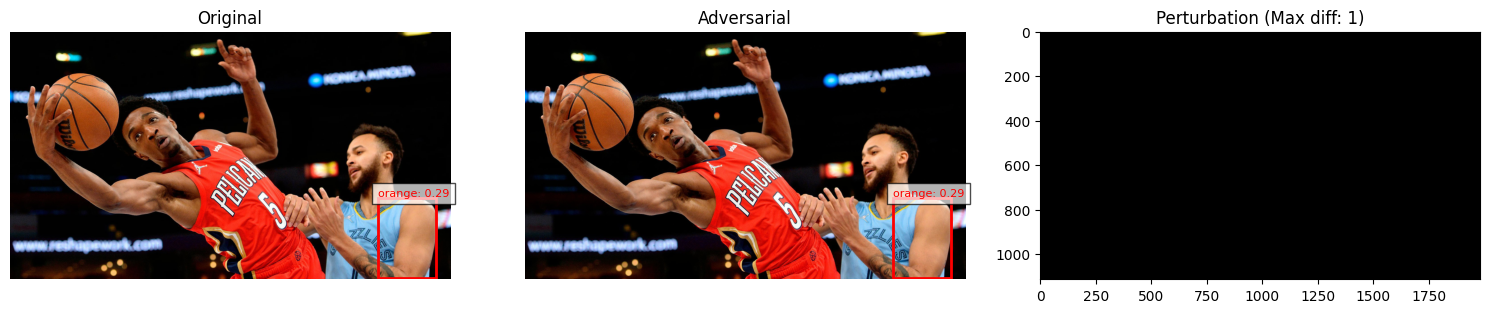


Original Detections:
Detection 1:
- Class: orange
- Confidence: 0.29
- Bounding Box: [     1653.9      746.03      1917.6      1107.8]

Adversarial Detections:
Detection 1:
- Class: orange
- Confidence: 0.29
- Bounding Box: [     1653.6      745.86      1917.6      1107.9]

Maximum pixel difference: 1


In [3]:
# Load your trained model
model_path = "/Users/lastjan/Development/KI die 2/JupyterProject/.../best.pt"
model = YOLO(model_path)

# Test with epsilon = 0 (should show identical results)
fgsm = FGSMAttack(model, epsilon=0.01)

# Load an image
image_path = "/Users/lastjan/Development/KI die 2/JupyterProject/dataset/images/test/Basketball.jpg"
image = Image.open(image_path)

# Generate and visualize attack
fgsm.visualize_attack(image, save_path="attack_results.png")

In [23]:
from ultralytics import YOLO
import numpy as np
import torch
from pathlib import Path
from PIL import Image
from art.estimators.object_detection import PyTorchYolo
from art.attacks.evasion import FastGradientMethod
import shutil

class YOLOv8Wrapper:
    def __init__(self, model_path):
        self.model = YOLO(model_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Convert model parameters to double precision
        self.model = self.model.to(dtype=torch.float64)
        self.model.to(self.device)

    def get_art_model(self):
        return PyTorchYolo(
            model=self.model.model.double(),  # Ensure model is in double precision
            input_shape=(3, 640, 640),
            clip_values=(0.0, 1.0),
            preprocessing=(0.0, 1.0)
        )

def process_image(image_path):
    """
    Load and preprocess image with double precision
    """
    # Load image
    image = Image.open(image_path).convert('RGB')
    image_array = np.array(image)

    # Convert to PyTorch tensor with double precision
    image_tensor = torch.from_numpy(image_array).double()
    image_tensor = image_tensor.permute(2, 0, 1)  # CHW format

    # Normalize to [0, 1]
    image_tensor = image_tensor / 255.0

    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)

    # Convert back to numpy array in double precision
    return image_tensor.numpy()

def generate_adversarial_examples(
    source_folder,
    output_folder,
    model_path,
    epsilon=0.03,
    batch_size=1
):
    """
    Generate adversarial examples using FGSM and save them to the output folder.
    """
    output_path = Path(output_folder)
    output_path.mkdir(parents=True, exist_ok=True)

    # Initialize model
    print("Initializing model...")
    wrapper = YOLOv8Wrapper(model_path)
    art_model = wrapper.get_art_model()

    # Initialize FGSM attack
    print("Setting up FGSM attack...")
    attack = FastGradientMethod(
        estimator=art_model,
        eps=float(epsilon),  # Cast to Python float
        eps_step=float(epsilon),
        targeted=False,
        batch_size=batch_size,
        minimal=True
    )

    # Process images
    source_path = Path(source_folder)
    image_files = list(source_path.glob('*.jpg')) + list(source_path.glob('*.png'))

    for img_path in image_files:
        try:
            print(f"\nProcessing {img_path.name}...")

            # Load and preprocess image
            image_tensor = process_image(img_path)

            # Print tensor information for debugging
            print(f"Input tensor dtype: {image_tensor.dtype}")
            print(f"Input tensor shape: {image_tensor.shape}")
            print(f"Input tensor range: [{image_tensor.min()}, {image_tensor.max()}]")

            # Generate adversarial example
            print("Generating adversarial example...")
            adversarial_tensor = attack.generate(x=image_tensor)

            # Convert back to image format
            adversarial_image = adversarial_tensor.transpose(0, 2, 3, 1)[0]
            adversarial_image = (adversarial_image * 255.0).clip(0, 255).astype(np.uint8)

            # Save adversarial example
            adv_image = Image.fromarray(adversarial_image)
            output_file = output_path / f"adversarial_{img_path.name}"
            adv_image.save(output_file)

            print(f"Saved adversarial example to {output_file}")

            # Calculate perturbation
            original_image = np.array(Image.open(img_path))
            perturbation = np.abs(original_image - adversarial_image)
            print(f"Max perturbation: {np.max(perturbation)}")
            print(f"Mean perturbation: {np.mean(perturbation):.2f}")

        except Exception as e:
            print(f"Error processing {img_path.name}")
            print(f"Error details: {str(e)}")
            print(f"Error type: {type(e)}")
            import traceback
            print("Full traceback:")
            print(traceback.format_exc())

def main():
    # Configuration
    SOURCE_FOLDER = "/Users/lastjan/Development/KI die 2/JupyterProject/dataset/images/test"  # Replace with your source folder
    OUTPUT_FOLDER = "/Users/lastjan/Development/KI die 2/JupyterProject/dataset/images/testFGSM"  # Replace with your output folder
    MODEL_PATH = "/Users/lastjan/Development/KI die 2/JupyterProject/.../best.pt"  # Replace with your model path

    # FGSM parameters
    EPSILON = 0.03  # Attack strength (can be adjusted)
    BATCH_SIZE = 1

    print("Starting adversarial example generation...")
    generate_adversarial_examples(
        source_folder=SOURCE_FOLDER,
        output_folder=OUTPUT_FOLDER,
        model_path=MODEL_PATH,
        epsilon=EPSILON,
        batch_size=BATCH_SIZE
    )
    print("Completed!")

if __name__ == "__main__":
    main()

Starting adversarial example generation...
Initializing model...
Setting up FGSM attack...

Processing Winter-Fishing-On-Ice-sealed-Chagan-Lake.jpg...
Input tensor dtype: float64
Input tensor shape: (1, 3, 1066, 1600)
Input tensor range: [0.0, 1.0]
Generating adversarial example...
Error processing Winter-Fishing-On-Ice-sealed-Chagan-Lake.jpg
Error details: Minimal perturbation is only supported for classification.
Error type: <class 'ValueError'>
Full traceback:
Traceback (most recent call last):
  File "/var/folders/02/3djmv0rd6nnb958868zjrcl40000gn/T/ipykernel_93958/2505198798.py", line 94, in generate_adversarial_examples
    adversarial_tensor = attack.generate(x=image_tensor)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lastjan/miniconda3/lib/python3.12/site-packages/art/attacks/evasion/fast_gradient.py", line 308, in generate
    raise ValueError("Minimal perturbation is only supported for classification.")
ValueError: Minimal perturbation is only supp

In [ ]:
def main():
    # Configuration
    SOURCE_FOLDER = "/Users/lastjan/Development/KI die 2/JupyterProject/dataset/images/test"  # Replace with your source folder
    OUTPUT_FOLDER = "/Users/lastjan/Development/KI die 2/JupyterProject/dataset/images/testFGSM"  # Replace with your output folder
    MODEL_PATH = "/Users/lastjan/Development/KI die 2/JupyterProject/.../best.pt"  # Replace with your model path

    # FGSM parameters
    EPSILON = 0.03  # Attack strength (can be adjusted)
    BATCH_SIZE = 1